In [15]:
"""
TIP: 
    1. Never use  [[0]*3]*3 for array assignment - This creates three duplicate list. Check out below code to view the weird result it gives:
        X = [[2]*3]*2
        X[0][0] = 3
        print(X)
        #Extremely weired!!! This is assigning to all the coloumn 0th element to 3.
"""
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from math import *


class ONN:
    
    #Constants
    DEBUG = 1
    MU = 1                   # Oscillator parameter (>0 for supercritical)
    EPS = 0.9                # ε - coupling strength for error signal e(t) = D(t) - P(t)
    ETA_OMEGA = 0.1       #ηω - ωi' = -ηω*e(t)*sin(Фi) ; 1/η = 0.0001
    ETA_ALPHA = 0.0001       #ηα - αi' = ηα*e(t)*ri*cos(Фi)
    TAU = 10000              #τ - τ*Wij' = -Wij + zi(zj*)^(ωi/ωj)
    
    def __init__(self, N=30, NEPOCHS=100, DT=0.01):
        self.N = N
        self.NEPOCHS = NEPOCHS
        self.DT = DT
        
        self.initialize()
    
    def initialize(self):
        """
        Parameters:
        R:     Initialize everything to 1
        PHI:   2*pi*rand(n, 1) - Uniformly distributed random number from 0 - 2ℼ 
        W:     { 0.01 + 45*2*pi*rand(n,1) - Given} For now assign in steps of 5
        A:     Randomly assign betwwn 0-1 uniformly distributed (TODO: constrain this later)
        THETA: Randomly assign between 0 - 2ℼ uniformly distributed
        APLHA: Initialize all to 0.09

        Constrain:
        θ12 = -θ21 = θ
        A12 = A21 = A
        MU = 1
        
        Use coloumn vector to avoid ambiguity
        
        #Initialized at startup
        R = np.zeros([N, 1])          # R vector in polar coordinates for N oscillators
        PHI = np.zeros([N, 1])        # Ф vector for N oscillators
        OMEGA = np.zeros([N, 1])      # Natural frequencies of N oscillators
        A = np.zeros([N, N])          # NxN connectivity matrix for N oscillators
        THETA = np.zeros([N, N])      # NxN phase angle difference in complex coupling
        ALPHA = np.zeros([N, 1])      # NxN weight matrix for phase 1 teaching
        IEXT = np.zeros([N, 3])       # For each oscillator external input freq, phase and amplitude

        """
        self.R = 1*np.ones([self.N, 1]) 
        self.PHI = 2*pi*np.random.rand(self.N, 1)
        self.OMEGA = self.N*np.random.rand(self.N, 1)
        
        """
            (i) Aij = Aji (ii) Aii = 0
            (ii) θ12 = -θ21 = θ
            Note: Make sure Aii is always zero to avoid numerical issues
        """
        self.A = np.random.rand(self.N, 1)
        self.A = np.dot(self.A, self.A.T)
        self.A.fill(0.00001)
        np.fill_diagonal(self.A, 0)
        
        self.THETA = 2*pi*np.random.rand(self.N, self.N)
        self.THETA = (self.THETA - self.THETA.T)
        
        self.ALPHA = 1*np.ones([self.N, 1])
    
    def Preprocess(self, data):
        print("Preprocessing done...")
        return data
    
    def fit(self, data, sampling_rate=500):
        """
        Parameters:
        NEPOCHS: How long to run the model

        TODO: Later add Iext as well

        Return:
        W: Change in W
        PHI: Change in pahse
        N_PHI_DIFF: Normalized pahse difference

        Miscellaneous:
            1. Normalized pahse difference approaches zero ss individual oscillators attain equillibrium 
            2. No dynamics for Amplitude of lateral coupling i.e. dA = 0
        """
        self.DT = 1.0/sampling_rate
        data = self.Preprocess(data)
        self.NSAMPLES = len(data)
        
        # Be careful while changing these assignment!! Check out TIP section
        #N_PHI_DIFF = np.zeros([self.N, self.N, self.NEPOCHS]) 
        #PHI_ = np.zeros([self.N, self.NEPOCHS])
        #R_ = np.zeros([self.N, self.NEPOCHS])
        #THETA_ = np.zeros([self.N, self.N, self.NEPOCHS])
        
        self.OMEGA_ = np.zeros([self.N, self.NEPOCHS])
        self.SIG_ = np.zeros([self.NEPOCHS, self.NSAMPLES])
        self.ERR_ = np.zeros(self.NEPOCHS)
        
        for t in range(self.NEPOCHS):
            # Why are they initializing R and THETA in every epoch?
            self.R = 1*np.ones([self.N, 1]) 
            self.PHI = 2*pi*np.random.rand(self.N, 1)
            
            Reconstructed = np.zeros(self.NSAMPLES) 
            ERR = np.zeros(self.NSAMPLES)
            PTEACH = np.zeros(self.NSAMPLES)
            
            for S in range(self.NSAMPLES):
                
                PTEACH[S] = data[S]
                Reconstructed[S] = np.sum(self.ALPHA*np.cos(self.PHI))
                ERR[S] = PTEACH[S] - Reconstructed[S]

                """
                    1. Vector form - do simultaneous update 
                    2. Below system handles complex sinusiodal input
                    3. In all matrix rows contain source oscillator, and 
                       columns represent coupling to corresponding target oscillator

                    Caution:
                    Use coloumn vector for each oscillator to avoid confusion
                """

                NORM_FREQ = np.multiply(self.OMEGA, 1/self.OMEGA.T) 
                NORM_FREQ[np.isnan(NORM_FREQ)] = 0
                
                #Nij = ∅j/ωj - ∅i/ωi + θij/ωiωj
                NORM_PHASE = (self.PHI/self.OMEGA).T - (self.PHI/self.OMEGA) + self.THETA/(self.OMEGA*self.OMEGA.T) 
                
                #To be used for training lateral weights Nij 
                # ∅i/ωi - ∅j/ωj - θij/ωiωj
                PHASE_DIFF = (self.PHI/self.OMEGA) - (self.PHI/self.OMEGA).T - self.THETA/(self.OMEGA*self.OMEGA.T) 
                
                """
                    Causes of NaN
                    1. Negative entries in R matrix. Any negative entry in R results in NaN i.e. complex value
                """
                R_POW_NF = self.R.T
                
                ARG = self.OMEGA*NORM_PHASE
                ARG_2 = self.OMEGA*PHASE_DIFF
                R_COUPLED = self.A*R_POW_NF*np.cos(ARG)
                PHI_COUPLED = self.A*(R_POW_NF/self.R)*np.sin(ARG)
                R_COUPLED = np.sum(R_COUPLED, axis=1) 
                PHI_COUPLED = np.sum(PHI_COUPLED, axis=1)
                #Converting to coloumn vector
                R_COUPLED = R_COUPLED[:,None]
                PHI_COUPLED = PHI_COUPLED[:,None]
                
                dR = ( (ONN.MU - self.R**2)*self.R + R_COUPLED + ONN.EPS*ERR[S]*np.cos(self.PHI) )*self.DT 
                dPHI = ( self.OMEGA + PHI_COUPLED - ONN.EPS*(ERR[S]/self.R)*np.sin(self.PHI) )*self.DT 
                dOMEGA = -ONN.ETA_OMEGA*ERR[S]*np.sin(self.PHI)*self.DT
                dALPHA = ONN.ETA_ALPHA*ERR[S]*self.R*np.cos(self.PHI)*self.DT
                
                #Equation2
                COMPLEX_W = self.A*np.exp(1j*self.THETA/self.OMEGA.T)
                Z1 = self.R*np.exp(1j*self.PHI)
                Z2 = self.R.T*np.exp(-1j*self.PHI.T)
                Z2_SP = np.power(Z2, self.OMEGA/self.OMEGA.T)

                dCOMPLEX_W = (-COMPLEX_W + Z1*Z2_SP)
                COMPLEX_W = COMPLEX_W + dCOMPLEX_W/ONN.ETA_OMEGA

                self.R = self.R + dR
                self.PHI = self.PHI + dPHI
                self.OMEGA = self.OMEGA + dOMEGA
                self.ALPHA = self.ALPHA + dALPHA
                self.THETA = np.angle(COMPLEX_W)*self.OMEGA.T
                
                """
                    Corrections:
                    1. Non-negative oscillator frequencies
                    2. Entries in R mtrix should not be negative
                """
                #Restrict frequencies of oscillator to positive range only
                self.OMEGA[self.OMEGA < 0.01] = 0.01 
                #This avoids NaN restricting R to non-negative values
                self.R[self.R < 0.01] = 0.01    
                #This avoids NaN due to 'A' term in the denominator in dTHETA
                np.fill_diagonal(self.THETA, 0) 
                np.fill_diagonal(self.A, 0)
            
            #Consider sum of squares error
            self.ERR_[t] = np.sum(np.abs(ERR))
            self.OMEGA_[:,t] = self.OMEGA.T
            self.SIG_[t] = Reconstructed
            
            #self.R_[:,t] = self.R.T
            #self.PHI_[:,t] = self.PHI.T
            #self.N_PHI_DIFF[:,:,t] = self.NORM_PHASE
            #self.THETA_[:,:,t] = self.THETA
            
            print("End of epoch {}". format(t))
        
    def Test_Signal(self):
        self.sampling_rate = 100
        signal = 0
        NSAMPLES = 10000
        dt = 1.0/self.sampling_rate

        time = np.linspace(0, (NSAMPLES-1)*dt, NSAMPLES)

        Amplitude = np.random.rand(self.N)[:,None]
        Freq = np.array([1 + i*1 for i in range(self.N)])[:,None]
        Phase = np.random.uniform(low=-pi, high=pi, size=(self.N, 1)) 
        
        signal = np.sum(Amplitude*np.sin( Freq*time + Phase), axis=0)

        return signal

In [27]:
o = ONN(N=30, NEPOCHS=2)
DATA = o.Test_Signal()
print(DATA.shape)
o.fit(DATA, sampling_rate=100)

(10000,)
Preprocessing done...
End of epoch 0
End of epoch 1


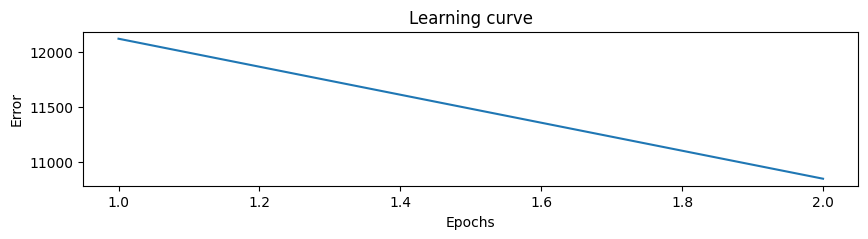

In [28]:
epochs = np.linspace(1, o.NEPOCHS, o.NEPOCHS)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(2)
plt.title("Learning curve")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.plot(epochs, o.ERR_)
plt.show()

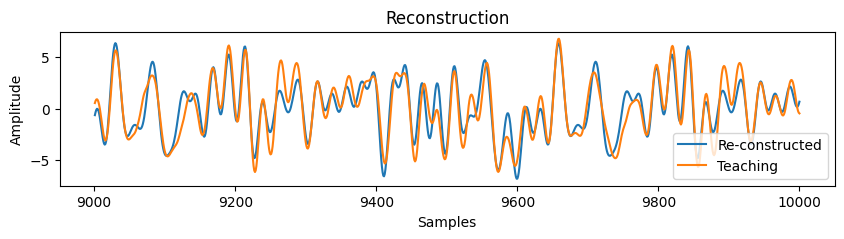

In [29]:
samples = np.linspace(1, o.NSAMPLES, o.NSAMPLES)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(2)
plt.title("Reconstruction")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.plot(samples[o.NSAMPLES-1000:o.NSAMPLES], DATA[o.NSAMPLES-1000:o.NSAMPLES])
plt.plot(samples[o.NSAMPLES-1000:o.NSAMPLES], o.SIG_[o.NEPOCHS-1][o.NSAMPLES-1000:o.NSAMPLES])
plt.legend({'Teaching', 'Re-constructed'})
plt.show()

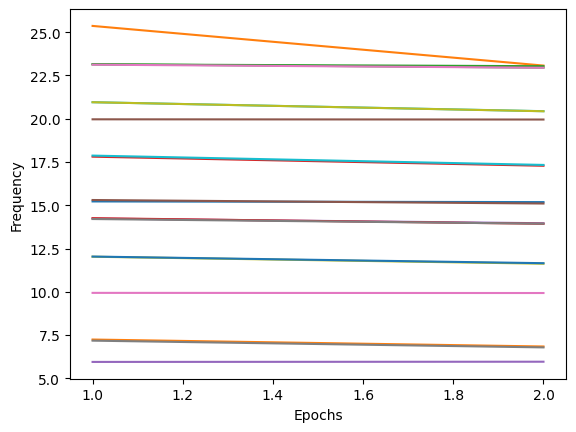

In [25]:
epochs = np.linspace(1, o.NEPOCHS, o.NEPOCHS)
plt.xlabel("Epochs")
plt.ylabel("Frequency")
for i in range(len(o.OMEGA_)):
    plt.plot(epochs, o.OMEGA_[i])
plt.show()

OMEGA 
 [[ 4.70223688]
 [19.82253091]
 [26.4299981 ]
 [11.54451017]
 [29.9781527 ]
 [28.58771436]
 [11.94724562]
 [18.80242794]
 [10.72197042]
 [19.22596747]
 [ 8.64119427]
 [16.87916065]
 [ 6.85835503]
 [ 2.16540412]
 [20.71237921]
 [ 0.93821753]
 [29.52909665]
 [ 8.21280927]
 [ 5.47584102]
 [ 1.70123723]
 [18.00945517]
 [ 2.45437315]
 [15.99663804]
 [25.21461457]
 [17.28626795]
 [14.05750934]
 [16.19459026]
 [ 7.56272028]
 [12.92025076]
 [17.13191338]]
PHI 
 [[2.97386573e+00]
 [5.49087095e+00]
 [4.94814581e+00]
 [5.00108857e+00]
 [2.60329561e+00]
 [2.83280007e+00]
 [3.64254839e+00]
 [1.51440419e+00]
 [6.10186909e+00]
 [1.75861225e+00]
 [2.44407413e+00]
 [2.89591318e-02]
 [2.58718169e+00]
 [1.17255362e-01]
 [3.62226543e+00]
 [5.40498118e+00]
 [2.82967364e+00]
 [3.73170705e+00]
 [2.78966334e+00]
 [5.40180536e+00]
 [4.71827716e+00]
 [1.68755380e+00]
 [6.89676520e-01]
 [5.40191965e-03]
 [4.88920981e+00]
 [4.54138105e+00]
 [4.71551763e+00]
 [5.99690705e+00]
 [8.43023391e-01]
 [5.62307362e

/tmp/ipykernel_1099936/2417742070.py:100: RuntimeWarning: divide by zero encountered in divide
  dTHETA = ((OMEGA.T*R*R_POW_NF/A)*np.sin(ARG_2))
/tmp/ipykernel_1099936/2417742070.py:100: RuntimeWarning: invalid value encountered in multiply
  dTHETA = ((OMEGA.T*R*R_POW_NF/A)*np.sin(ARG_2))


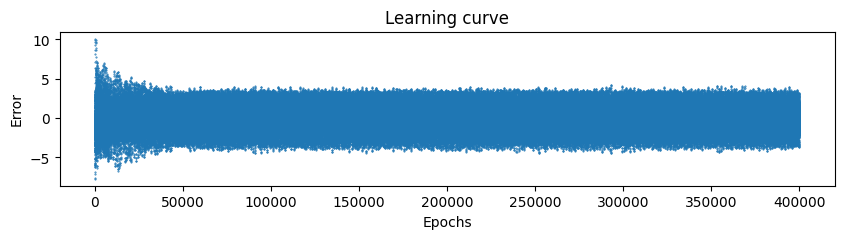

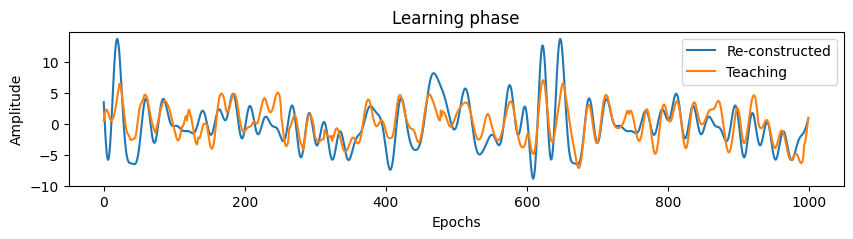

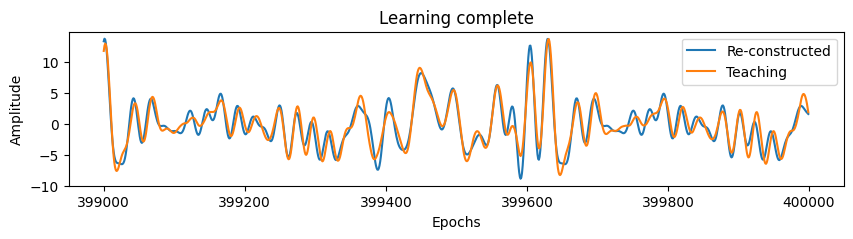

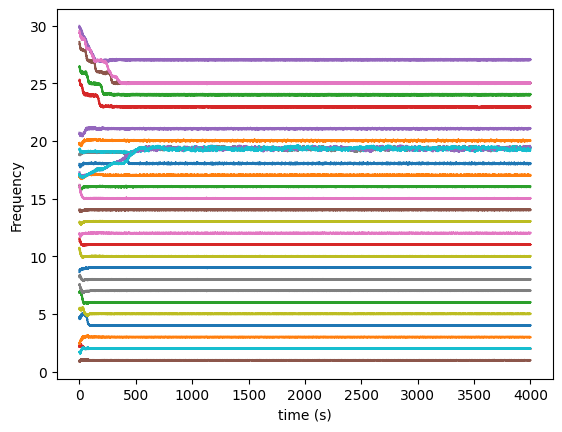

In [5]:
R, PHI, OMEGA, A, THETA, ALPHA, IEXT = initialize(N)
R, PHI, R_, PHI_, OMEGA_, N_PHI_DIFF, THETA_, ERR_, PTEACH_, S_ = model(N, R, PHI, OMEGA, A, THETA, ALPHA, IEXT, NEPOCHS, DATA_SAMPLES)

epochs = [i for i in range(NEPOCHS)]
t = np.multiply(epochs, DT)
X = [np.multiply(R_[i], np.cos(PHI_[i])) for i in range(N)] 

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(2)

plt.title("Learning curve")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.scatter(epochs, ERR_, s=0.2)
plt.show()

#Before learning
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(2)

plt.title("Learning phase")
plt.xlabel("Epochs")
plt.ylabel("Amplitude")
plt.plot(epochs[0:1000], PTEACH_[0:1000])
plt.plot(epochs[0:1000], S_[0:1000])
plt.legend({'Teaching', 'Re-constructed'})
plt.show()

#Post learning
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(2)

plt.title("Learning complete")
plt.xlabel("Epochs")
plt.ylabel("Amplitude")
plt.plot(epochs[NEPOCHS-1000:NEPOCHS], PTEACH_[NEPOCHS-1000:NEPOCHS])
plt.plot(epochs[NEPOCHS-1000:NEPOCHS], S_[NEPOCHS-1000:NEPOCHS])
plt.legend({'Teaching', 'Re-constructed'})
plt.show()

plt.xlabel("time (s)")
plt.ylabel("Frequency")
for i in range(len(X)):
    plt.plot(t, OMEGA_[i])
plt.show()

#plt.xlabel("time (s)")
#plt.ylabel("Normalized phase diff")
#for i in range(N):
#    for j in range(N):
#        if i != j:
#            plt.plot(t, N_PHI_DIFF[i][j])
#plt.show()

#plt.xlabel("time (s)")
#plt.ylabel("Angle of lateral weight")
#for i in range(N):
#    for j in range(N):
#        if i != j:
#            #plt.plot(t, THETA_[i][j])
#            plt.scatter(t, THETA_[i][j], s=0.2)
#plt.show()


In [9]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.
